<a href="https://colab.research.google.com/github/Sucheta97/Gen-AI-GAN/blob/main/_Capstone_GAN_based_Image_Generation_using_CIFAR_10_using_DCGAN_CGAN_AND_WGAN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


# GAN-based Image Generation using CIFAR-10  
## DCGAN → Conditional GAN → WGAN-GP

### Dataset
CIFAR-10 (Canadian Institute for Advanced Research)

### Classes
- **Vehicles**: airplane, automobile, ship, truck  
- **Animals**: bird, cat, deer, dog, frog, horse

This notebook is **fully runnable** and generates images during training.


## 1. Imports & Global Configuration

In [1]:

import tensorflow as tf
from tensorflow.keras import layers
import numpy as np
import matplotlib.pyplot as plt

LATENT_DIM = 100
BATCH_SIZE = 64
EPOCHS = 30
NUM_CLASSES = 10


## 2. Load CIFAR-10 Dataset

In [2]:

(x_train, y_train), (_, _) = tf.keras.datasets.cifar10.load_data()

# Normalize to [-1, 1]
x_train = (x_train.astype('float32') / 127.5) - 1.0

dataset = tf.data.Dataset.from_tensor_slices((x_train, y_train))
dataset = dataset.shuffle(60000).batch(BATCH_SIZE)


170498071/170498071 ━━━━━━━━━━━━━━━━━━━━ 6s 0us/step


## 3. Visualize Real CIFAR-10 Images

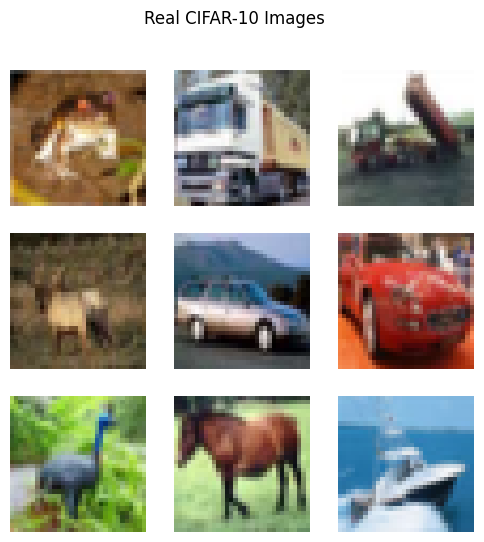

In [3]:

plt.figure(figsize=(6,6))
for i in range(9):
    plt.subplot(3,3,i+1)
    plt.imshow((x_train[i] + 1) / 2)
    plt.axis('off')
plt.suptitle("Real CIFAR-10 Images")
plt.show()



# 4. DCGAN (Baseline Image GAN)

DCGAN uses convolutional layers for stable image generation.


In [4]:

def build_dcgan_generator():
    model = tf.keras.Sequential([
        layers.Dense(8*8*256, input_shape=(LATENT_DIM,)),
        layers.Reshape((8,8,256)),

        layers.Conv2DTranspose(128, 4, strides=2, padding='same'),
        layers.BatchNormalization(),
        layers.ReLU(),

        layers.Conv2DTranspose(64, 4, strides=2, padding='same'),
        layers.BatchNormalization(),
        layers.ReLU(),

        layers.Conv2DTranspose(3, 3, padding='same', activation='tanh')
    ])
    return model

def build_dcgan_discriminator():
    model = tf.keras.Sequential([
        layers.Conv2D(64, 4, strides=2, padding='same',
                      input_shape=(32,32,3)),
        layers.LeakyReLU(0.2),

        layers.Conv2D(128, 4, strides=2, padding='same'),
        layers.LeakyReLU(0.2),

        layers.Flatten(),
        layers.Dense(1, activation='sigmoid')
    ])
    return model

dcgan_gen = build_dcgan_generator()
dcgan_disc = build_dcgan_discriminator()


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [5]:

bce = tf.keras.losses.BinaryCrossentropy()
gen_opt = tf.keras.optimizers.Adam(0.0002, beta_1=0.5)
disc_opt = tf.keras.optimizers.Adam(0.0002, beta_1=0.5)

@tf.function
def dcgan_train_step(images):
    noise = tf.random.normal([tf.shape(images)[0], LATENT_DIM])

    with tf.GradientTape() as gt, tf.GradientTape() as dt:
        fake = dcgan_gen(noise, training=True)
        real_out = dcgan_disc(images, training=True)
        fake_out = dcgan_disc(fake, training=True)

        g_loss = bce(tf.ones_like(fake_out), fake_out)
        d_loss = bce(tf.ones_like(real_out), real_out) +                  bce(tf.zeros_like(fake_out), fake_out)

    gen_opt.apply_gradients(zip(gt.gradient(g_loss, dcgan_gen.trainable_variables),
                                dcgan_gen.trainable_variables))
    disc_opt.apply_gradients(zip(dt.gradient(d_loss, dcgan_disc.trainable_variables),
                                 dcgan_disc.trainable_variables))
    return g_loss


## DCGAN Training & Output

DCGAN Epoch 5


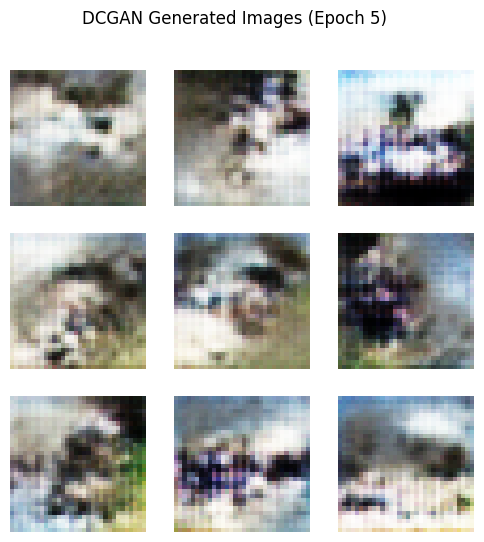

DCGAN Epoch 10


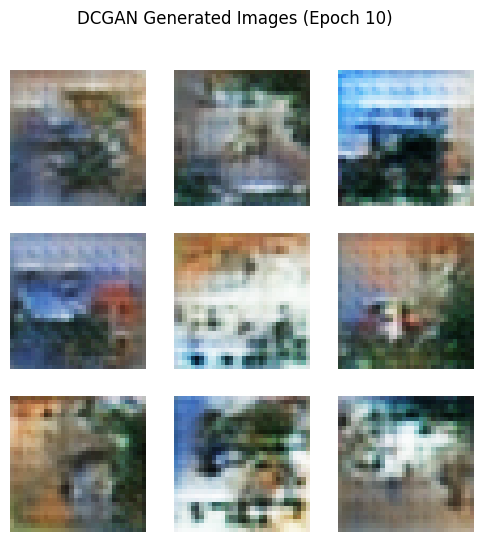

DCGAN Epoch 15


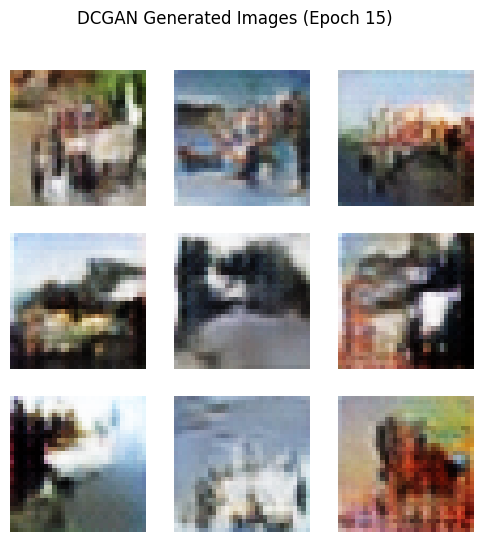

DCGAN Epoch 20


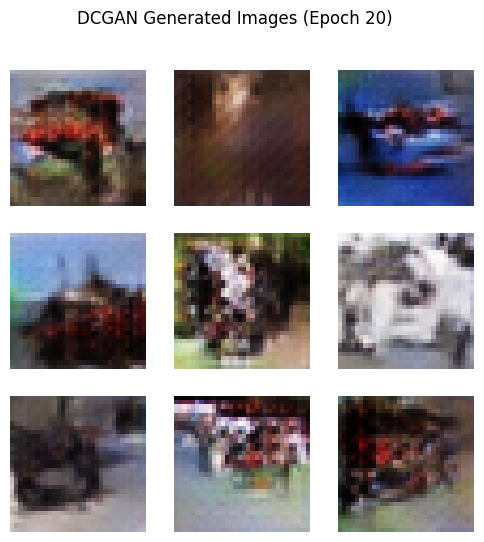

DCGAN Epoch 25


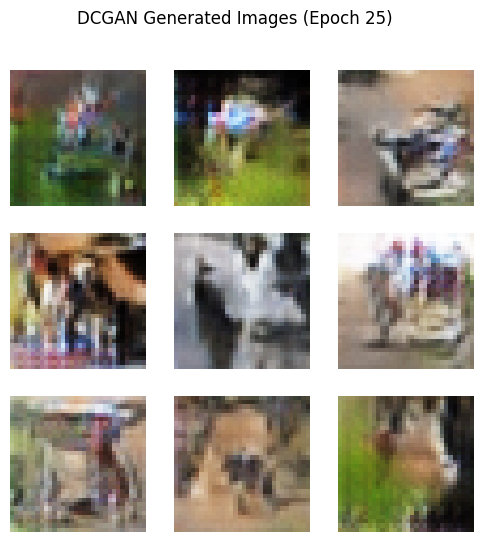

DCGAN Epoch 30


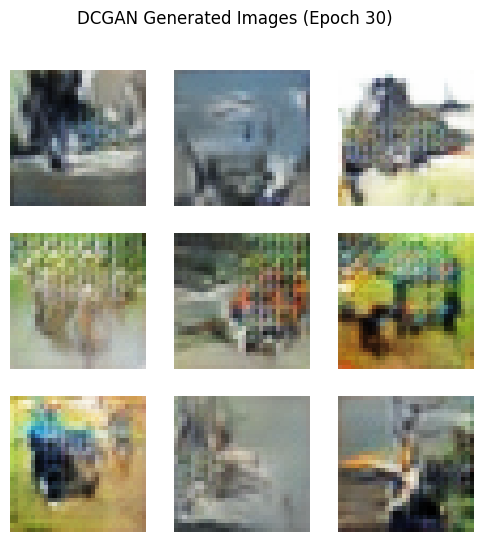

In [6]:

def show_images(model, title):
    noise = tf.random.normal([9, LATENT_DIM])
    imgs = model(noise, training=False)

    plt.figure(figsize=(6,6))
    for i in range(9):
        plt.subplot(3,3,i+1)
        plt.imshow((imgs[i] + 1) / 2)
        plt.axis('off')
    plt.suptitle(title)
    plt.show()

for epoch in range(1, EPOCHS+1):
    for imgs, _ in dataset:
        dcgan_train_step(imgs)

    if epoch % 5 == 0:
        print(f"DCGAN Epoch {epoch}")
        show_images(dcgan_gen, f"DCGAN Generated Images (Epoch {epoch})")



# 5. Conditional GAN (Vehicle vs Animal)

Generator and Discriminator are conditioned on CIFAR-10 labels.


In [8]:

def build_cgan_generator():
    noise = layers.Input(shape=(LATENT_DIM,))
    label = layers.Input(shape=(1,), dtype='int32')

    label_emb = layers.Embedding(NUM_CLASSES, LATENT_DIM)(label)
    label_emb = layers.Flatten()(label_emb)

    x = layers.Concatenate()([noise, label_emb])
    x = layers.Dense(8*8*256)(x)
    x = layers.Reshape((8,8,256))(x)

    x = layers.Conv2DTranspose(128, 4, strides=2, padding='same')(x)
    x = layers.ReLU()(x)

    x = layers.Conv2DTranspose(64, 4, strides=2, padding='same')(x)
    x = layers.ReLU()(x)

    out = layers.Conv2DTranspose(3, 3, padding='same', activation='tanh')(x)
    return tf.keras.Model([noise, label], out)

cgan_gen = build_cgan_generator()



## Conditional Generation Demo

Generate images by specifying class labels:
- Vehicle classes: 0,1,8,9
- Animal classes: 2–7


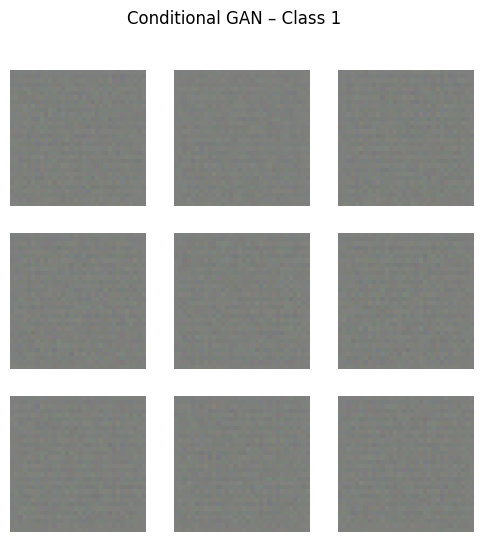

In [9]:

def generate_conditional_images(model, label):
    noise = tf.random.normal([9, LATENT_DIM])
    labels = tf.ones((9,1), dtype=tf.int32) * label
    imgs = model([noise, labels], training=False)

    plt.figure(figsize=(6,6))
    for i in range(9):
        plt.subplot(3,3,i+1)
        plt.imshow((imgs[i] + 1) / 2)
        plt.axis('off')
    plt.suptitle(f"Conditional GAN – Class {label}")
    plt.show()

generate_conditional_images(cgan_gen, label=1)



# 6. WGAN-GP (Industry-Preferred Stable GAN)

Uses Wasserstein loss + Gradient Penalty.


In [10]:

def build_critic():
    model = tf.keras.Sequential([
        layers.Conv2D(64, 4, strides=2, padding='same',
                      input_shape=(32,32,3)),
        layers.LeakyReLU(0.2),

        layers.Conv2D(128, 4, strides=2, padding='same'),
        layers.LeakyReLU(0.2),

        layers.Flatten(),
        layers.Dense(1)
    ])
    return model

critic = build_critic()
wgan_gen = build_dcgan_generator()


/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [11]:

LAMBDA_GP = 10
gen_opt = tf.keras.optimizers.Adam(1e-4, beta_1=0.0, beta_2=0.9)
crit_opt = tf.keras.optimizers.Adam(1e-4, beta_1=0.0, beta_2=0.9)

def gradient_penalty(real, fake):
    alpha = tf.random.uniform([tf.shape(real)[0],1,1,1])
    interpolated = real + alpha * (fake - real)

    with tf.GradientTape() as tape:
        tape.watch(interpolated)
        pred = critic(interpolated, training=True)

    grads = tape.gradient(pred, interpolated)
    norm = tf.sqrt(tf.reduce_sum(tf.square(grads), axis=[1,2,3]))
    return tf.reduce_mean((norm - 1.0) ** 2)


In [12]:
@tf.function
def wgan_train_step(images):
    noise = tf.random.normal([tf.shape(images)[0], LATENT_DIM])

    with tf.GradientTape() as gt, tf.GradientTape() as ct:
        fake = wgan_gen(noise, training=True)

        real_score = critic(images, training=True)
        fake_score = critic(fake, training=True)

        gp = gradient_penalty(images, fake)

        c_loss = tf.reduce_mean(fake_score) - tf.reduce_mean(real_score) + LAMBDA_GP * gp
        g_loss = -tf.reduce_mean(fake_score)

    crit_opt.apply_gradients(zip(ct.gradient(c_loss, critic.trainable_variables),
                                  critic.trainable_variables))
    gen_opt.apply_gradients(zip(gt.gradient(g_loss, wgan_gen.trainable_variables),
                                 wgan_gen.trainable_variables))

    return g_loss

## WGAN-GP Training & Output

WGAN-GP Epoch 5


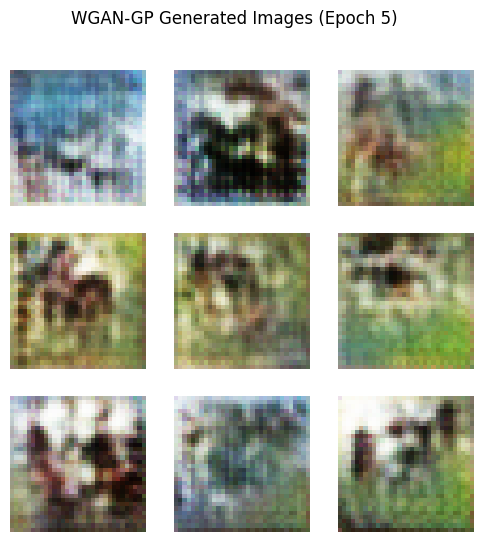

WGAN-GP Epoch 10


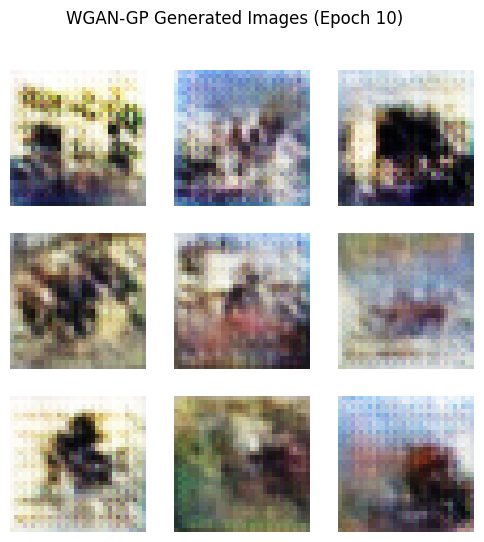

WGAN-GP Epoch 15


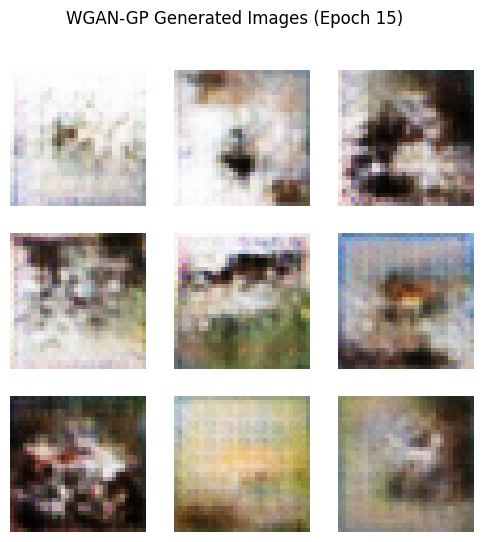

WGAN-GP Epoch 20


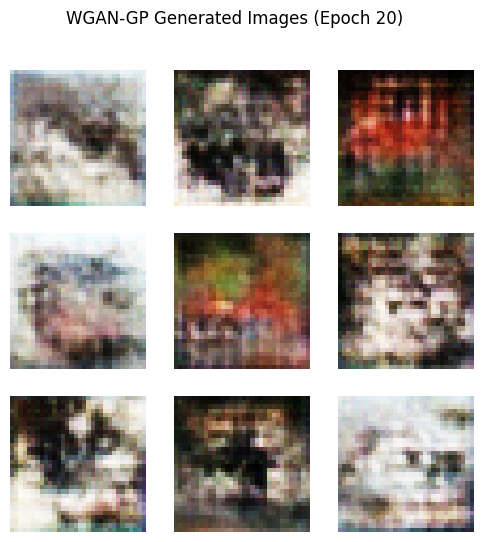

WGAN-GP Epoch 25


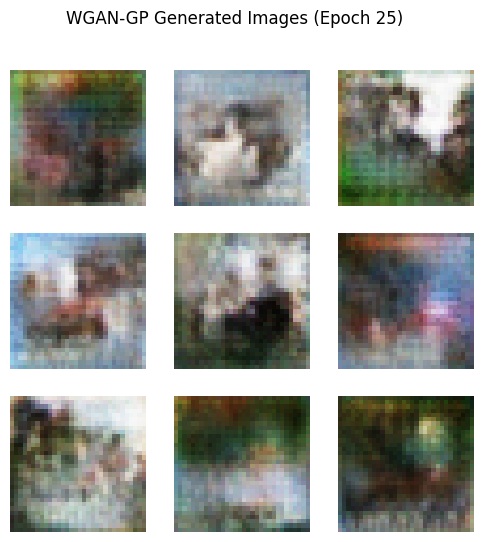

WGAN-GP Epoch 30


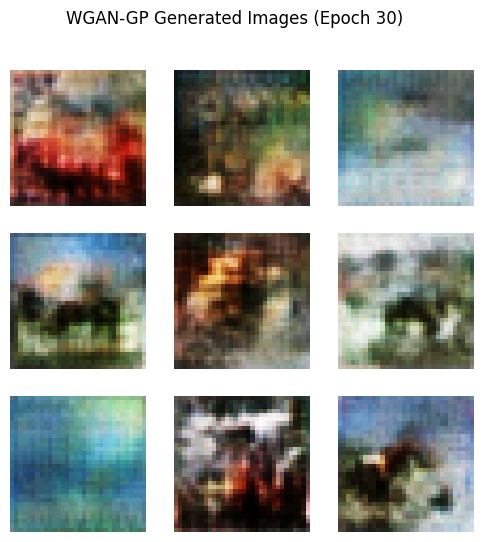

In [13]:

for epoch in range(1, EPOCHS+1):
    for imgs, _ in dataset:
        wgan_train_step(imgs)

    if epoch % 5 == 0:
        print(f"WGAN-GP Epoch {epoch}")
        show_images(wgan_gen, f"WGAN-GP Generated Images (Epoch {epoch})")



## Final Comparison

- **DCGAN**: Good baseline image quality  
- **Conditional GAN**: Controlled generation (vehicle vs animal)  
- **WGAN-GP**: Most stable and industry-preferred  


